In [15]:
# Preprocess Data

import pandas as pd

df = pd.read_csv("players_stats_23-24.csv")

# Drop irrelevant columns
columns_to_drop = ['id', 'name', 'status', 'news_added', 'news', 
                   'starts_per_90', 'goals_conceded', 'clean_sheets_per_90', 'creativity_rank_type', 
                   'creativity_rank', 'penalties_saved', 'penalties_missed', 'bonus', 'own_goals', 
                   'penalties_order', 'corners_and_indirect_freekicks_order', 'transfers_out', 'transfers_out_event']
df = df.drop(columns=columns_to_drop)

# Handle missing values
df = df.dropna()

# Normalize/Scale numeric columns
from sklearn.preprocessing import StandardScaler

numeric_columns = ['now_cost', 'expected_goals', 'expected_assists', 'total_points', 'form', 'minutes', 'selected_by_percent', 'clean_sheets']
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

print(df.head())


    now_cost position         team      web_name  transfers_in_event  \
10  0.806724      MID      Arsenal    Martinelli                8293   
12  1.184339      MID      Arsenal      Ødegaard               39933   
27 -0.434013      MID      Arsenal          Rice               12376   
44 -0.811628      DEF  Aston Villa         Digne               54202   
45 -0.380068      MID  Aston Villa  Douglas Luiz               72232   

    influence_rank_type  ict_index_rank_type  assists  selected_rank  \
10                   59                   18        2             67   
12                   15                    8        4             24   
27                   10                   41        1             73   
44                   41                    5        3             70   
45                    7                   20        3             52   

    direct_freekicks_order  ...  now_cost_rank_type  ict_index  now_cost_rank  \
10                     3.0  ...                  11  

In [16]:
# K means Clustering 

from sklearn.cluster import KMeans

# KMeans clustering
X = df[numeric_columns]
kmeans = KMeans(n_clusters=4, random_state=42) 
df['cluster'] = kmeans.fit_predict(X)

# Check which players are in the low-ownership/high-potential cluster
# Filter out the cluster with high xG/xA and low ownership
differentials = df[(df['cluster'] == 0) & (df['selected_by_percent'] < 10)]  # <10% ownership
print(differentials[['web_name', 'selected_by_percent', 'expected_goals', 'expected_assists', 'form', 'total_points']])


      web_name  selected_by_percent  expected_goals  expected_assists  \
73     Billing            -0.540797       -0.120701         -0.180686   
96   Tavernier            -0.477785       -0.042710          0.039497   
123     Jensen            -0.501415       -0.711210          0.243953   
152       Dunk            -0.336007       -0.206121         -0.275050   
244       Enzo            -0.367513        0.744635         -0.054867   
286    Edouard            -0.406896        1.004608         -0.990645   
287        Eze            -0.351760        0.410385          0.118134   
297      Olise            -0.532921       -0.272971          0.000179   
319     Garner            -0.564427       -0.258116          0.251816   
335      Young            -0.548674       -0.770633         -0.613188   
370    Willian            -0.493538        0.414099         -0.330096   
426    Doughty            -0.540797       -0.774347          0.196771   
453    Barkley            -0.556550       -0.499519

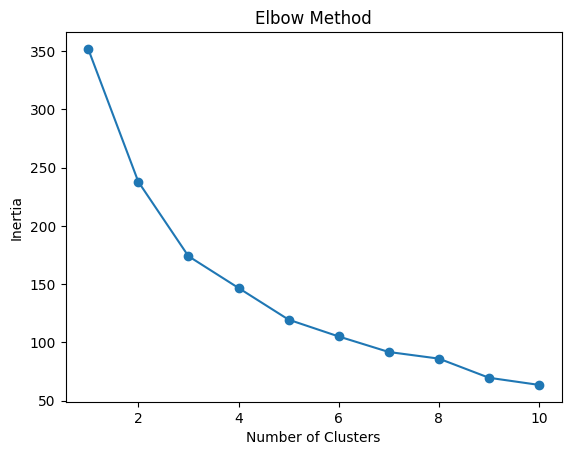

In [17]:
# Elbow method to find optimal number of K

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
range_of_k = range(1, 11)  # Try k from 1 to 10

for k in range_of_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the results
plt.plot(range_of_k, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()


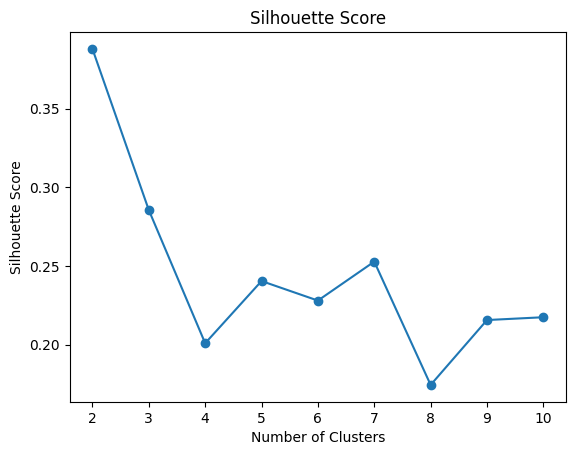

The optimal number of clusters is: 2


In [18]:
# Silhouette Score to find optimal number of K
import numpy as np
from sklearn.metrics import silhouette_score

sil_scores = []
range_of_k = range(2, 11)  # Start from k = 2

for k in range_of_k:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sil_score = silhouette_score(X, kmeans.labels_)
    sil_scores.append(sil_score)

# Plot the results
plt.plot(range_of_k, sil_scores, marker='o')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show() 

optimal_k = range_of_k[np.argmax(sil_scores)]
print(f"The optimal number of clusters is: {optimal_k}")


In [ ]:
# Isolation Forest for anomaly detection

from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.1)  # 10% will be anomalies
df['anomaly'] = model.fit_predict(X)

# Look at players that are anomalies (overperforming relative to ownership)
differentials_anomalies = df[df['anomaly'] == -1]
print(differentials_anomalies[['web_name', 'selected_by_percent', 'expected_goals', 'expected_assists', 'form', 'total_points']])


             web_name  selected_by_percent  expected_goals  expected_assists  \
382  Alexander-Arnold             0.987255       -0.369532          1.250504   
469         De Bruyne            -0.438402       -0.885763         -1.352374   
474           Haaland             4.232397        4.659078         -0.558142   
562          Trippier             2.846123       -0.800344          2.909740   
688               Son             2.885506        1.509697          1.415641   

         form  total_points  
382  2.921168      1.433418  
469 -1.180390     -1.696979  
474 -0.131154      2.251590  
562  0.155001      1.255554  
688  2.015010      2.607317  
